In [8]:
# !pip install osmnx

## O Algoritmo de Kruskal

- Ordena todas as aresteas do grafo em ordem crescente de peso.
- Adiciona as arestas ao conjunto da MST uma por vez, desde que não formem ciclos.
- Utiliza a estrutura de dados Union-Find para detectar ciclos.
- Complexidade: O(E log E), onde E é o número de arestas.

In [9]:
import osmnx as ox
import networkx as nx
import matplotlib.pyplot as plt

In [10]:
def to_undirected_multigraph(G):
    """
    Converte um MultiDiGraph direcionado em um MultiGraph não-direcionado,
    preservando atributos dos nós e arestas.
    """
    H = nx.MultiGraph()
    # Copiar nós e seus atributos
    for n, data in G.nodes(data=True):
        H.add_node(n, **data)

    # Copiar arestas e seus atributos, sem direcionamento
    for u, v, data in G.edges(data=True):
        # Em um MultiGraph, se já existir uma aresta u-v, esta será adicionada como mais uma aresta paralela
        H.add_edge(u, v, **data)

    # Copiar atributos do grafo
    H.graph.update(G.graph)
    return H

In [11]:
# ============================================
# 1. Obter o grafo da cidade de Natal
# ============================================
place = "Natal, Rio Grande do Norte, Brazil"
G = ox.graph_from_place(place, network_type='drive')

# Converte para não-direcionado mantendo o tipo MultiGraph
G_undirected = to_undirected_multigraph(G)

Comprimento total do MST entre os POIs selecionados: 123250.06359962653 metros


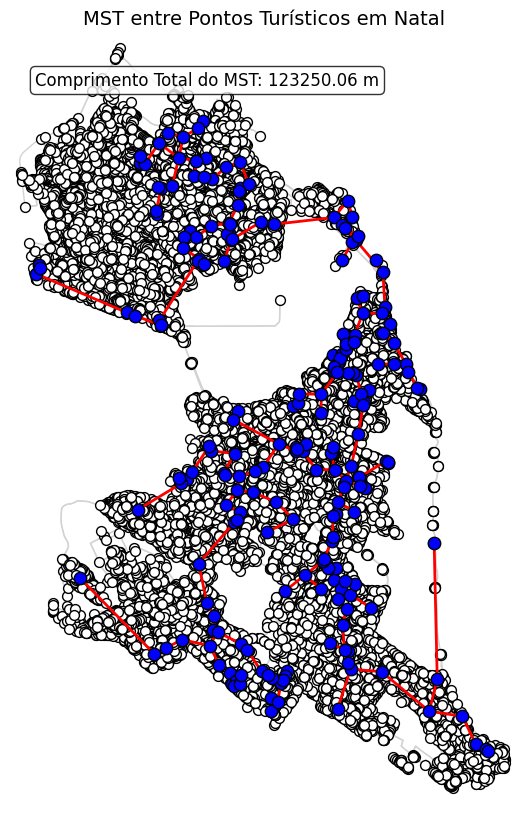

In [12]:
# ============================================
# 2. Obter POIs de interesse (hospitais como exemplo)
# ============================================
tags = {
    'natural': 'beach',
    'tourism': 'museum',
    'historic': 'monument',
    'amenity': 'place_of_worship',
    'boundary': 'national_park'
}
pois = ox.features.features_from_place(place, tags=tags)

poi_points = []
poi_colors = []  # Lista para armazenar as cores dos POIs
tag_colors = {
    'natural': 'blue',
    'tourism': 'purple',
    'historic': 'green',
    'amenity': 'red',
    'boundary': 'orange'
}

for idx, row in pois.iterrows():
    if row.geometry.geom_type == 'Point':
        poi_points.append((row.geometry.y, row.geometry.x))
    else:
        poi_points.append((row.geometry.centroid.y, row.geometry.centroid.x))

    # Associar uma cor com base nas tags
    color_assigned = False
    for tag, color in tag_colors.items():
        if tag in row.keys() and row[tag]:
            poi_colors.append(color)
            color_assigned = True
            break
    if not color_assigned:
        poi_colors.append('gray')

# ============================================
# 3. Encontrar nós mais próximos dos POIs
# ============================================
latitudes = [hp[0] for hp in poi_points]
longitudes = [hp[1] for hp in poi_points]
poi_nodes = ox.distance.nearest_nodes(G_undirected, X=longitudes, Y=latitudes)
poi_nodes = list(set(poi_nodes))

# ============================================
# 4. Construir um grafo completo com menor rota entre POIs
# ============================================
G_interest = nx.Graph()
for i in range(len(poi_nodes)):
    for j in range(i + 1, len(poi_nodes)):
        route = nx.shortest_path(G_undirected, poi_nodes[i], poi_nodes[j], weight='length')
        route_length = sum(G_undirected[route[k]][route[k+1]][0]['length'] for k in range(len(route)-1))
        G_interest.add_edge(poi_nodes[i], poi_nodes[j], weight=route_length)

# ============================================
# 5. Calcular o MST
# ============================================
mst_edges = list(nx.minimum_spanning_edges(G_interest, data=True))
total_mst_length = sum([d['weight'] for (u, v, d) in mst_edges])
print("Comprimento total do MST entre os POIs selecionados:", total_mst_length, "metros")

# ============================================
# Plotar o grafo base
# ============================================
fig, ax = ox.plot_graph(
    G_undirected,
    show=False,
    close=False,
    node_color='white',
    node_edgecolor='black',
    node_size=50,
    edge_color='lightgray',
    edge_linewidth=1,
    bgcolor='white',
    figsize=(10, 10)
)

# Destacar as rotas do MST em vermelho
for u, v, d in mst_edges:
    x = [G_undirected.nodes[u]['x'], G_undirected.nodes[v]['x']]
    y = [G_undirected.nodes[u]['y'], G_undirected.nodes[v]['y']]
    ax.plot(x, y, color='red', linewidth=2, zorder=4)

# Plotar os POIs
poi_x = [G_undirected.nodes[n]['x'] for n in poi_nodes]
poi_y = [G_undirected.nodes[n]['y'] for n in poi_nodes]
for i in range(len(poi_x)):
    ax.scatter(poi_x[i], poi_y[i], c=poi_colors[i], s=80, zorder=5, edgecolor='black')

# Adicionar comprimento total do MST no gráfico
ax.text(
    0.05, 0.95, f"Comprimento Total do MST: {total_mst_length:.2f} m",
    transform=ax.transAxes,
    fontsize=12,
    verticalalignment='top',
    bbox=dict(boxstyle="round", facecolor="white", alpha=0.8)
)

plt.title("MST entre Pontos Turísticos em Natal", fontsize=14)
plt.show()
